In [131]:
import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.DataFrame(pd.read_excel("/kaggle/input/final-data/final_data.xlsx"))


In [134]:
df['IITK02']=df['IITK02'].interpolate()

In [135]:
df['IITK02'].isna().sum()

0

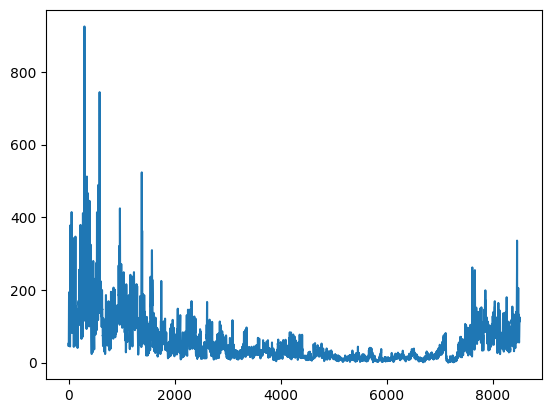

In [136]:
timeseries = df[["IITK02"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

In [137]:
timeseries

array([[ 46.666668],
       [ 51.333332],
       [ 54.25    ],
       ...,
       [112.5     ],
       [125.25    ],
       [114.      ]], dtype=float32)

In [138]:
# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [139]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


In [140]:
import torch

In [141]:

lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([6803, 1, 1]) torch.Size([6803, 1, 1])
torch.Size([1700, 1, 1]) torch.Size([1700, 1, 1])


In [142]:
import torch.nn as nn
 
class lstmModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
#         x = x[:, -1, :]
        x = self.linear(x)
        return x

In [143]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [144]:

import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = lstmModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
#         train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        train_r2 = r2_loss(y_pred, y_train)
        y_pred = model(X_test)
#         test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        test_r2 = r2_loss(y_pred, y_test)
    print("Epoch %d: train R2 %.4f, test R2 %.4f" % (epoch, train_r2, test_r2))

Epoch 0: train R2 -0.1014, test R2 -0.4153
Epoch 10: train R2 0.7666, test R2 0.9141
Epoch 20: train R2 0.8506, test R2 0.9114
Epoch 30: train R2 0.8635, test R2 0.9104
Epoch 40: train R2 0.8638, test R2 0.9061
Epoch 50: train R2 0.8811, test R2 0.9054
Epoch 60: train R2 0.8725, test R2 0.9129
Epoch 70: train R2 0.8845, test R2 0.8884
Epoch 80: train R2 0.8816, test R2 0.8933
Epoch 90: train R2 0.8842, test R2 0.9100
Epoch 100: train R2 0.8816, test R2 0.8685
Epoch 110: train R2 0.8807, test R2 0.8926
Epoch 120: train R2 0.8893, test R2 0.9127
Epoch 130: train R2 0.8845, test R2 0.9121
Epoch 140: train R2 0.8920, test R2 0.9116
Epoch 150: train R2 0.8886, test R2 0.9058
Epoch 160: train R2 0.8990, test R2 0.9128
Epoch 170: train R2 0.8781, test R2 0.8801
Epoch 180: train R2 0.8688, test R2 0.8927
Epoch 190: train R2 0.8990, test R2 0.9045
Epoch 200: train R2 0.8926, test R2 0.8998
Epoch 210: train R2 0.8853, test R2 0.8771
Epoch 220: train R2 0.8849, test R2 0.9118
Epoch 230: train R2 

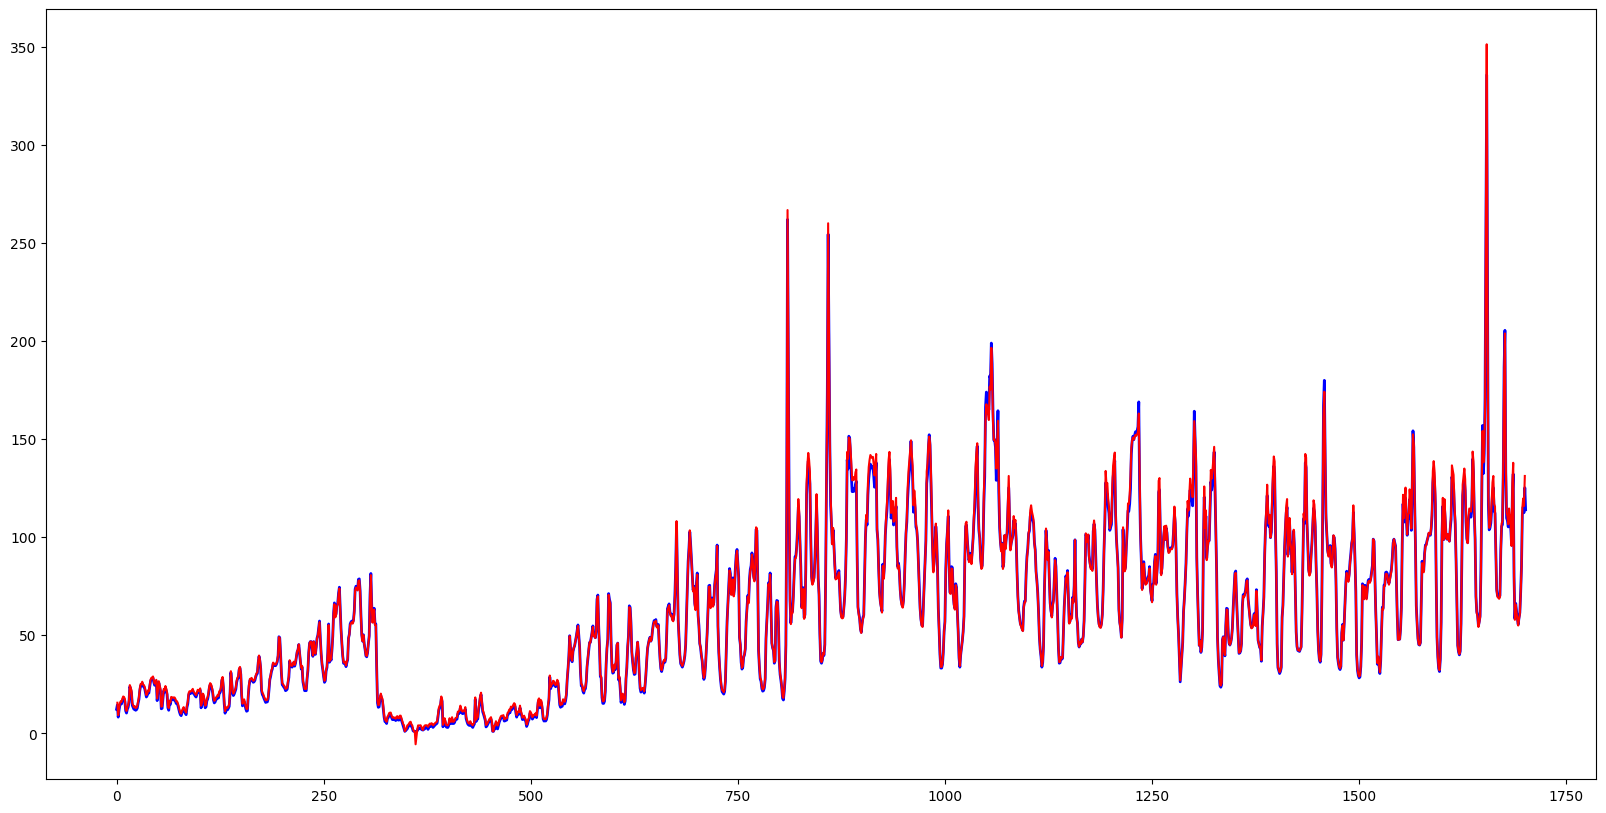

In [147]:

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries[6804:]) * np.nan
    test_plot[lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.figure(figsize=(20,10))
plt.plot(timeseries[6803:], c='b', label = 'original',linewidth=2.0)

plt.plot(test_plot, c='r',label='predicted values')
plt.show()
